<a href="https://colab.research.google.com/github/leorumma/arvore-decisao-v2/blob/main/arvore-decisao-parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from seaborn import heatmap
import matplotlib.pyplot as plt
import random

#criar os gráficos das árvores de decisão
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

In [2]:
def print_decision_tree(decision_tree_clf, feature_names):
    # tem que usar feature_names = one_hot_data.columns pois feature_names = feature_cols tem menos atributos
    # pois o one-hot acrescenta mais
    dot_data = StringIO()
    export_graphviz(decision_tree_clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_names, class_names=['No','Yes'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    #graph.write_png('arvore1.png')
    clf_image_png = graph.create_png()
    
    Image(clf_image_png)

In [3]:
#link para o dataset: 
DATASET_URL = 'https://drive.google.com/uc?id=1JCdSHO1lHj06qpV92tigrovhzJQbcr1h&confirm=t'
dataset = pd.read_csv(DATASET_URL)
original_dataset = dataset.copy()

In [4]:
dataset.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
#Iniciando análise exploratória dos dados

In [6]:
#Sem valores não preenchidos nas colunas
print(len(dataset))
print(len(dataset.dropna()))

6362620
6362620


In [7]:
print(dataset.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [8]:
#tipos de pagamento/transação
type_unique_values = dataset['type'].unique()
print(type_unique_values)
print(len(type_unique_values))

#Conclusão: podemos(e faz sentido) categorizar esses dados e utilizarmos para treinar nosso classificador

['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
5


In [9]:
# origens dos pagamentos
nameOrig_unique_values = dataset['nameOrig'].unique()
print(nameOrig_unique_values)
print(len(nameOrig_unique_values))

#Conclusão: poderíamos utilizar o get_dummies aqui, mas isso faria por adicionar 6353307 colunas
# ao nosso dataset, o que é inviável(acho eu)

['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807']
6353307


In [10]:
# origens dos pagamentos
nameDest_unique_values = dataset['nameDest'].unique()
print(nameDest_unique_values)
print(len(nameDest_unique_values))

#Conclusão: o mesmo acima vale para o atributo nameDest, vai ser dificil utilizar

['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513']
2722362


| Máximo | Mediana | Mínimo | : | 59585040.37 | 14208.0 | 0.0 |


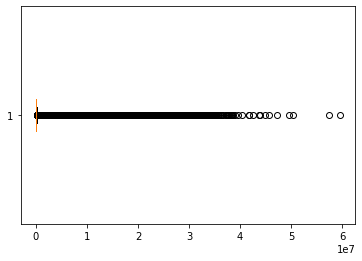

In [11]:
#Boxplot do oldbalanceOrg
print('| Máximo | Mediana | Mínimo | : | {0} | {1} | {2} |'\
      .format(dataset['oldbalanceOrg'].max(), dataset['oldbalanceOrg'].median(), dataset['oldbalanceOrg'].min()))
bplots = plt.boxplot(dataset['oldbalanceOrg'],  vert = 0)

| Máximo | Mediana | Mínimo | : | 49585040.37 | 0.0 | 0.0 |


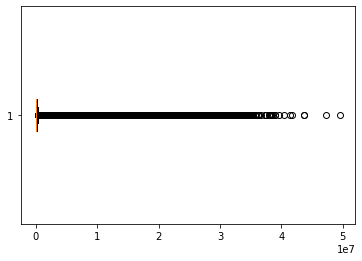

In [12]:
#Boxplot do newbalanceOrig
print('| Máximo | Mediana | Mínimo | : | {0} | {1} | {2} |'\
      .format(dataset['newbalanceOrig'].max(), dataset['newbalanceOrig'].median(), dataset['newbalanceOrig'].min()))
bplots = plt.boxplot(dataset['newbalanceOrig'],  vert = 0)

| Máximo | Mediana | Mínimo | : | 356015889.35 | 132705.66499999998 | 0.0 |


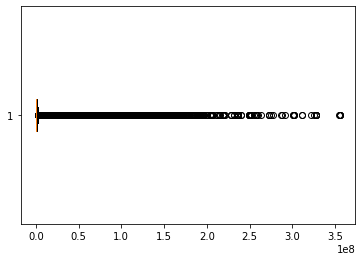

In [13]:
#Boxplot do oldbalanceDest
print('| Máximo | Mediana | Mínimo | : | {0} | {1} | {2} |'\
      .format(dataset['oldbalanceDest'].max(), dataset['oldbalanceDest'].median(), dataset['oldbalanceDest'].min()))
bplots = plt.boxplot(dataset['oldbalanceDest'],  vert = 0)

| Máximo | Mediana | Mínimo | : | 356179278.92 | 214661.44 | 0.0 |


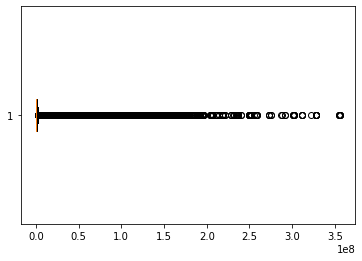

In [14]:
#Boxplot do newbalanceDest
print('| Máximo | Mediana | Mínimo | : | {0} | {1} | {2} |'\
      .format(dataset['newbalanceDest'].max(), dataset['newbalanceDest'].median(), dataset['newbalanceDest'].min()))
bplots = plt.boxplot(dataset['newbalanceDest'],  vert = 0)

In [15]:
# Conclusão a partir dos boxplots dos balanços: posso reduzir o número de colunas, 
# considerar somente o valor que entrou na conta de destino e saiu da conta de origem

| Máximo | Mediana | Mínimo | : | 743 | 239.0 | 1 |


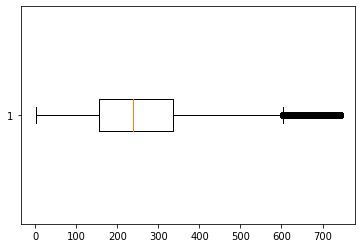

In [16]:
# Boxplot da coluna step
print('| Máximo | Mediana | Mínimo | : | {0} | {1} | {2} |'\
      .format(dataset['step'].max(), dataset['step'].median(), dataset['step'].min()))
bplots = plt.boxplot(dataset['step'],  vert = 0)

<AxesSubplot:>

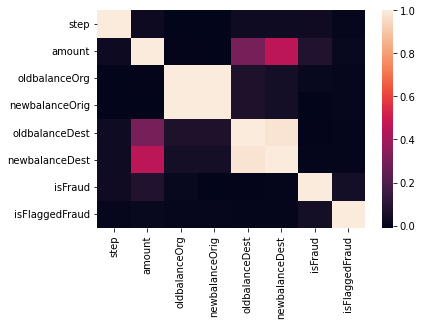

In [17]:
heatmap(dataset.corr())

In [18]:
#Transformação do dataset, seleção das features

dataset['balanceDeltaOrig'] = original_dataset['newbalanceOrig'] - original_dataset['oldbalanceOrg']
dataset['balanceDeltaDest'] = original_dataset['newbalanceDest'] - original_dataset['oldbalanceDest']

feature_cols = ['amount','oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
target_col = 'isFraud'

dummy_columns = ['type']

prepared_dummy_columns = pd.get_dummies(dataset[dummy_columns])

combined = pd.concat([dataset, prepared_dummy_columns], axis=1)

feature_cols.extend(prepared_dummy_columns.columns.values.tolist())

X = combined[feature_cols]
y = combined[target_col]

X.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [24]:
#Treino
test_percentage = 0.05
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=test_percentage)

# Criação do classificador de árvore de decisão 
clf = DecisionTreeClassifier(criterion="entropy")

# Usamos o método fit para construir o classificador a partir do nosso conjunto de treinamento
clf = clf.fit(X_train, y_train)

train_accuracy = clf.score(X_train, y_train)

# Usando modelo para classificar os dados que temos a disposição
y_pred = clf.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_pred)

print('| Train accuracy | Test accuracy | : | {0} | {1} |'.format(train_accuracy, test_accuracy))

| Train accuracy | Test accuracy | : | 1.0 | 0.999789394934791 |


In [21]:
#print_decision_tree(clf, X.columns)

In [ ]:
#Teste
random_element = random.randint(0, len(X))
sample = X.iloc[[random_element]]
target_of_sample = y.iloc[[random_element]]

pred_sample = clf.predict(sample)

print(pred_sample)
print(target_of_sample)